In [2]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import joblib
import os

Using TensorFlow backend.


In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [4]:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #X.append(data[in_start:in_end, :])
            #y.append(data[in_end:out_end, 0])
            X.append(data[in_start:in_end,0])
            y.append(data[in_end:out_end,0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [5]:
def model_fit(train, config):
    #config
    n_input, n_nodes, n_epochs, n_batch, n_in, n_out = config
    #data preparation
    train_x, train_y = to_supervised(train, n_input, n_out)    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    n_features = 1
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dropout(0.15)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse', metrics=['mse','accuracy'])
    #model.compile(optimizer='adam', loss='mse')
    # fit model
    history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch ,verbose=1, shuffle=False)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    #pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    return model

In [6]:
def model_predict(model, train, test, config):
    n_input,_,_,_,n_in, n_out = config
    #data test preparation   
    history = [x for x in train]
#    test_x, test_y = to_supervised(history, n_input, n_out)
#    x_input = array(test_x[0]).reshape((1, n_input, 1))
    predictions = list()
#    batch = x_input
    # forecast
    print(len(test), 'mediciones')
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
        print("\rProcessing file {} ({}%)".format(i+1, 100*(i+1)//len(test)),sep=' ', end='', flush = True)
    # evaluate predictions days for each week
    predictions = array(predictions)    
    return predictions, test

In [7]:
# make a forecast
def forecast(model, history, n_input):
    data = array(history)
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [8]:
####
#n_input: The number of lag observations to use as input to the model, in min (?)
#n_nodes: The number of LSTM units to use in the hidden layer.
#n_epochs: The number of times to expose the model to the whole training dataset.
#n_batch: The number of samples within an epoch after which the weights are updated.
#n_in: The difference order or 0 if not use
#n_out:
config1 = [30, 60, 10, 1440, 30, 1] #datatest.csv - 
config2 = [90, 60, 10, 1440, 90, 1] #datatest.csv - 
config3 = [120, 120, 10, 1440, 120, 1] #datatest.csv - 
config4 = [120, 120, 10, 128, 120, 1] #datatest.csv - 
config1y = [120, 60, 10, 1440, 120, 1] #data1y.csv - 

configtest1 = [120, 60, 10, 1440, 120, 1] #data1y.csv

config3y = [30, 120, 10, 1440, 30, 1] #data1y.csv
config4y = [180, 60, 10, 1440, 180, 1] #data1y.csv

config= config4
filename = 'config4_1ydata7200ntest.model'

hidden_nodes = int(2/3 * (config[0] * config[5]))
print("The number of hidden nodes is" , hidden_nodes)

The number of hidden nodes is 80


In [9]:
#load dataset, Time(UTC),prs(m),rad(m)
df = pd.read_csv('data1y.csv',sep=',', header=0, index_col=0, squeeze=True, parse_dates=True)
#non-null object to float64
df['prs(m)'] = pd.to_numeric(df['prs(m)'], errors='coerce')
#prs(m) looks more stable
df.drop(df.columns[[1]], axis=1, inplace=True)


In [10]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

prs(m)    150
dtype: int64

In [11]:
df.shape

(514640, 1)

In [12]:
s = df.interpolate()

In [13]:
print(s[s.isnull().any(axis=1)][null_columns])

Empty DataFrame
Columns: [prs(m)]
Index: []


In [14]:
null_columns=s.columns[s.isnull().any()]
s[null_columns].isnull().sum()

Series([], dtype: float64)

In [15]:
values = s.values

#Future label encoder
#encoder = LabelEncoder()
#Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [23]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
#60*24 daily ~ 1440 measurements
#n_test = test_size
n_test = 60*24*5

train , test = train_test_split(scaled, n_test)
print(len(train), len(test))

507440 7200






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





507320/507320 [==============================] - 1430s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - acc: 3.9423e-06
Epoch 2/10
507320/507320 [==============================] - 1497s 3ms/step - loss: 4.0393e-04 - mean_squared_error: 4.0393e-04 - acc: 3.9423e-06
Epoch 3/10
507320/507320 [==============================] - 1508s 3ms/step - loss: 2.9091e-04 - mean_squared_error: 2.9091e-04 - acc: 3.9423e-06
Epoch 4/10
507320/507320 [==============================] - 1452s 3ms/step - loss: 2.2221e-04 - mean_squared_error: 2.2221e-04 - acc: 3.9423e-06
Epoch 5/10
507320/507320 [==============================] - 1488s 3ms/step - loss: 2.1821e-04 - mean_squared_error: 2.1821e-04 - acc: 3.9423e-06
Epoch 6/10
507320/507320 [==============================] - 1

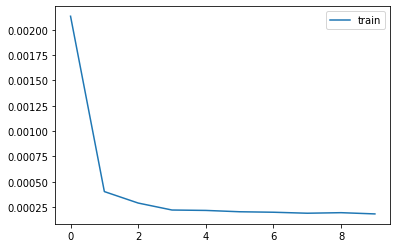

In [24]:
##save/load checkpoint
model = model_fit(train, config)
joblib.dump(model, filename)

loaded_model = joblib.load(filename)

In [25]:
#forecast
predictions_inv, real_inv = model_predict(loaded_model, train, test , config)

7200 mediciones
Processing file 7200 (100%)

In [26]:
#data set inverse
train = scaler.inverse_transform(train)
test = scaler.inverse_transform(test)

In [27]:
#invert scaling prediction
predictions = scaler.inverse_transform(predictions_inv)
#invert scaling actual
real_inv = real_inv.reshape((len(real_inv), 1))
real = scaler.inverse_transform(real_inv)

In [61]:
trainplot = train[-5000:]
trainplot.shape

(5000, 1)

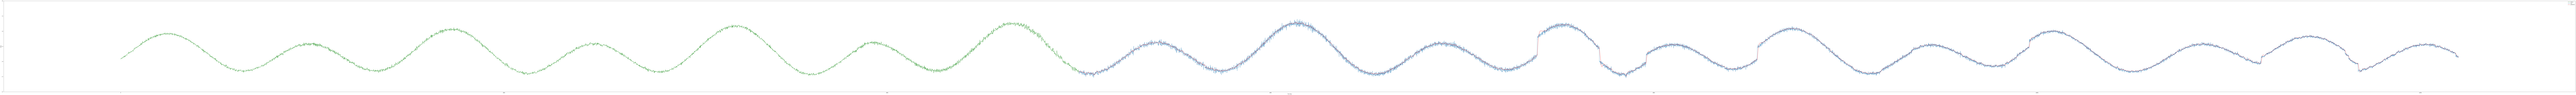

In [62]:
plt.rcParams["figure.figsize"] = (550,20)
plt.plot(np.arange(0, len(trainplot)), trainplot, 'g', label="history")
plt.plot(np.arange(len(trainplot), len(trainplot) + len(test)), test, marker='.', label="true")
plt.plot(np.arange(len(trainplot), len(trainplot) + len(test)), predictions, 'r', label="prediction")
plt.ylim(1, 4)
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

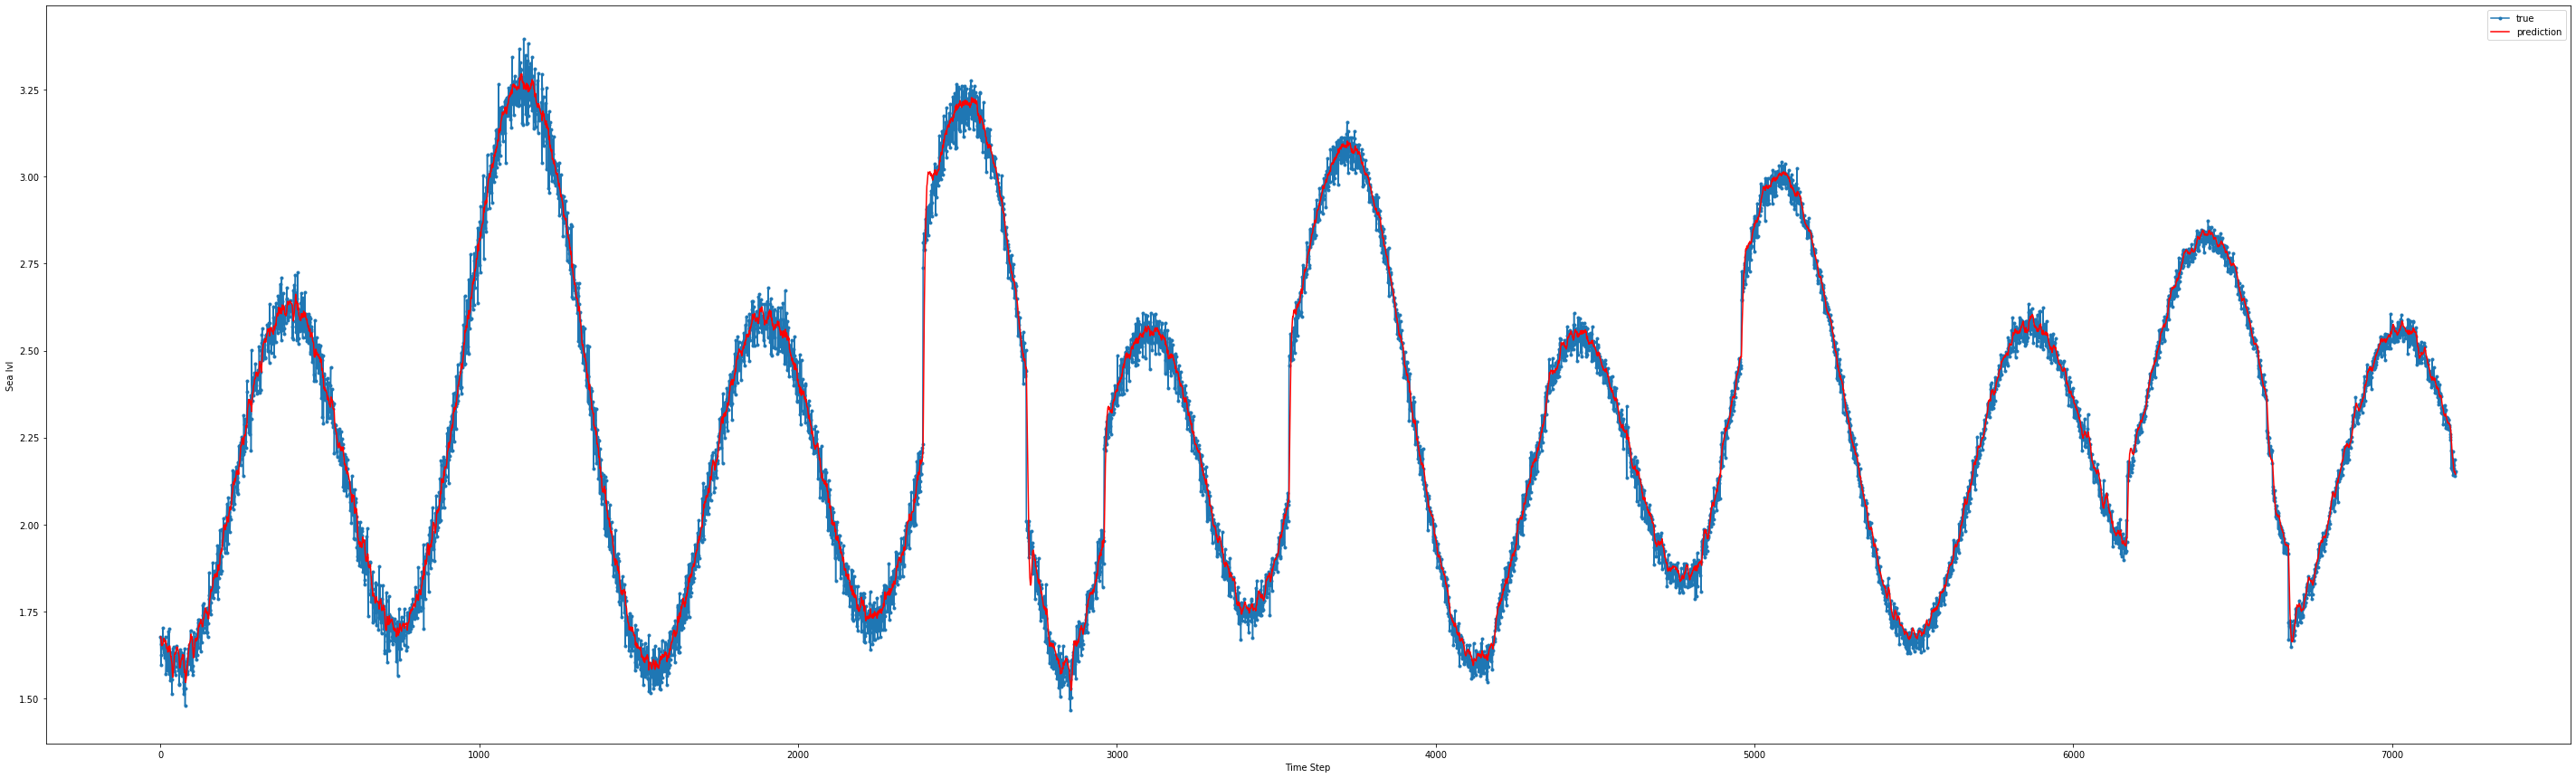

In [63]:
plt.rcParams["figure.figsize"] = (50,15)
plt.plot(test, marker='.', label="true")
plt.plot(predictions, 'r', label="prediction")
plt.ylabel('Sea lvl')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [31]:
mse = mean_squared_error(test, predictions)
sqrt(mse)

0.042882991007529424

In [32]:
#Latitude  -33.02730833
#Longitude -71.6259388
dfp = pd.DataFrame(predictions, index = df.index[-n_test:], columns =['prs(m) predictions'])

In [33]:
dfp

,prs(m) predictions
Time(UTC),
2018-12-24 08:43:17,1.677361
2018-12-24 08:44:17,1.676976
2018-12-24 08:45:17,1.667532
2018-12-24 08:46:17,1.653453
2018-12-24 08:47:17,1.651703
...,...
2018-12-29 23:55:18,2.151664
2018-12-29 23:56:18,2.149772
2018-12-29 23:57:18,2.152423


In [34]:
from ttide.t_tide import t_tide

#load dataset, Time(UTC),prs(m),rad(m)
df2 = pd.read_csv('data2y.csv',sep=',', header=0, index_col=0, squeeze=True, parse_dates=True)
#non-null object to float64
df2['prs(m)'] = pd.to_numeric(df2['prs(m)'], errors='coerce')
#prs(m) looks more stable
df2.drop(df2.columns[[1]], axis=1, inplace=True)

s = df2.interpolate()

out = t_tide(s['prs(m)'], dt=0.016, lat=-33.02730833)
#out = t_tide(dfp['prs(m) predictions'], dt=0.016, lat=np.array(-33.02730833))

C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_tide.py:345: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(lhs, rhs)[0].T
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\lib\type_check.py:161: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  return val.real
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\lib\type_check.py:204: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  return val.imag


-----------------------------------
nobs = 1036988 
ngood = 1036987 
record length (days) = 691.33
rayleigh criterion = 1.0

Phases at central time
x0= 2.31  xtrend= 0
var(data)= 0.14    var(prediction)= 0.00    var(residual)= 0.14
var(prediction)/var(data) (%) = 1.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0392     0.017    257.15     24.07       5.6
* SSA   0.0002282     0.0559     0.018      7.72     20.21        10
  MSM   0.0013098     0.0052     0.013    273.87    171.92      0.17
  MM    0.0015122     0.0115     0.015    224.21    102.30      0.58
  MSF   0.0028219     0.0026     0.011    109.92    197.89     0.055
  MF    0.0030501     0.0032     0.012    280.01    216.36     0.067
  ALP1  0.0343966     0.0011     0.013    110.16    225.08     0.007
  2Q1   0.0357064     0.0017     0.015    329.89    262.29     0.012
  SIG1  0.0359087     0.0015     0.018     39.39    236.

C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_utils.py:447: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  x = np.var(out['xingd'].real, ddof=1)
C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_utils.py:449: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  xr = np.var(out['xresgd'].real, ddof=1)


In [28]:
import utide